# Training notebook for "Cassava leaf disease classification" competition
### Author: Romain Chor
### January 2021

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import json
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.image as mpimg
import tensorflow as tf

warnings.filterwarnings("ignore")
sns.set()

In [3]:
# BASE PATHS
BASE_DIR = Path("../input/cassava-leaf-disease-classification") #Path to data directory
MODELS_DIR = Path("../input/cassavamodels") #Path to saved models: cassamodels (private dataset) for past saved models \ training for latest (version) saved models
IMAGE_DIR = Path(BASE_DIR, "train_images") #Path to images directory
OUTPUT_DIR = Path("./") #Path to 'output' directory

In [4]:
# Data importation
with open(Path(BASE_DIR, "label_num_to_disease_map.json"), 'r') as infile:
    map_classes = json.load(infile)
map_classes = {int(k):v for k, v in map_classes.items()}

data = pd.read_csv(Path(BASE_DIR, "train.csv"))
data['class_name'] = data['label'].map(map_classes)
data.head()

,image_id,label,class_name
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


## Keras

**TO TRY**
- Performance: running on TPU?
- Augmentations: resize with no crop
- Size: retry size 300x300
- Oversampling for class 0 (too few examples, lead to poor inference for this class)

In [5]:
# Tensorflow/Keras imports
from tensorflow.python.client import device_lib
from tensorflow.keras.backend import clear_session
from tensorflow.keras.mixed_precision import experimental as mixed_precision

from keras import Input
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception, InceptionV3, EfficientNetB0, EfficientNetB3
from keras.optimizers import Adam, SGD
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler


print(device_lib.list_local_devices())

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy) #shortens training time by 2x

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6979424767811767333
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 357632587141921283
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15687541056
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17298613792681383213
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5511607364602153744
physical_device_desc: "device: XLA_GPU device"
]


In [6]:
#Global variables
SEED = 117
IMAGE_SIZE = 512 #Parameter to choose wisely
TARGET_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [7]:
from keras.applications import ResNet50
from sklearn.cluster import KMeans
from toolbox import view_cluster

def extract_and_cluster(df, label, K=5):
    selection = df[df["label"] == label]
    selection["label"] = selection["label"].astype(str)
    
    model = ResNet50() #Pretrained NN
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
    flow = datagen.flow_from_dataframe(
        selection,
        IMAGE_DIR,
        x_col="image_id",
        y_col="label",
        class_mode="categorical",
        target_size=TARGET_SIZE,
        batch_size=32,
        shuffle=False
    )

    features = model.predict(flow, verbose=1)

    clt = KMeans(n_clusters=K, random_state=0)
    clt.fit(features)

    groups = {}
    for k in range(K):
        groups[k] = selection['image_id'].iloc[np.where(clt.labels_ == k)[0]].tolist()
        view_cluster(IMAGE_DIR, groups[k])
        
    return groups

In [8]:
class MonteCarloDropout(Dropout):
  def call(self, inputs):
    return super().call(inputs, training=True)

def build_model(model_name, num_classes=5, pretrained=True, freeze=True):
    weights = None
    trainable = True
    if pretrained:
        weights = "imagenet"
        if freeze:
            trainable = False
        
    base_model = getattr(tf.keras.applications, model_name)(include_top=False, 
                                                            weights=weights, 
                                                            input_shape=INPUT_SHAPE)
    base_model.trainable = trainable
    
    inputs = Input(shape=INPUT_SHAPE)
    x = base_model(inputs) #'training=False' allows keeping batch norm layers in inference mode when unfreezing
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x) #'training=True' to allow Monte-Carlo dropout (inference time dropout)
    outputs = Dense(5, activation="softmax", dtype='float32')(x)
    model = Model(inputs, outputs)
            
    return model


def build_flows(data_dict, preprocess_func, augments, params):
    train_datagen = ImageDataAugmentor(
        augment=augments["train"], 
        preprocess_input=preprocess_func,
        seed=SEED
    )
    test_datagen = ImageDataAugmentor(
        augment=augments["val"], 
        preprocess_input=preprocess_func, 
        seed=SEED
    )
    
    train_flow = train_datagen.flow_from_dataframe(
        data_dict["train"],
        IMAGE_DIR,
        x_col="image_id",
        y_col="label",
        class_mode="categorical",
        target_size=TARGET_SIZE,
        batch_size=params["train_bs"],
        seed=SEED
    )
    val_flow = test_datagen.flow_from_dataframe(
        data_dict["val"],
        IMAGE_DIR,
        x_col="image_id",
        y_col="label",
        class_mode="categorical",
        target_size=TARGET_SIZE,
        batch_size=params["val_bs"],
        shuffle=False,
        seed=SEED
    )
    
    return train_flow, val_flow

In [9]:
# Starting with a high LR would break the pre-trained weights. Moreover, LR should be increased accordingly with batch size for TPU optimization.
LR_START = 1e-5
LR_MAX = 1e-3
LR_MIN = 1e-5
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_scheduler = LearningRateScheduler(lrfn, verbose=True)

In [10]:
from keras.callbacks import Callback
from keras.backend import set_value, get_value
from keras import backend as Kk


class CosineAnnealingScheduler(Callback):
    """
        Cosine annealing scheduler.
    """
    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + np.cos(np.pi * epoch / self.T_max)) / 2
        set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = get_value(self.model.optimizer.lr)

In [11]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-qqtluzsf
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29530 sha256=0e336872150ecf2e4bae00e6231706a68f583415bd935d22bbdd3e60f9c260d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-5vggmwos/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [12]:
from sklearn.model_selection import train_test_split

df = data.copy()
df["label"] = df["label"].astype(str)
#Keeping a small test set for independant model evaluation
training_df, test_df = train_test_split(df, test_size=0.1, stratify=df["label"], random_state=SEED)

### Single model: train a model using a validation set

**HOW TO USE:**
- uncomment following cells (until separator) if needed
- change "model_name" value (!!! make sure the model is imported from keras.models !!!)
- set "preprocess_func" as the corresponding preprocessing function (also make sure it is imported)
- run all

102973440/102967424 [==============================] - 1s 0us/step
Found 1379 validated image filenames belonging to 1 classes.
44/44 [==============================] - 30s 671ms/step
Clipping cluster size from 57 to 5
Clipping cluster size from 341 to 5
Clipping cluster size from 312 to 5
Clipping cluster size from 289 to 5
Clipping cluster size from 380 to 5
Found 13422 validated image filenames belonging to 5 classes.
Found 5778 validated image filenames belonging to 5 classes.


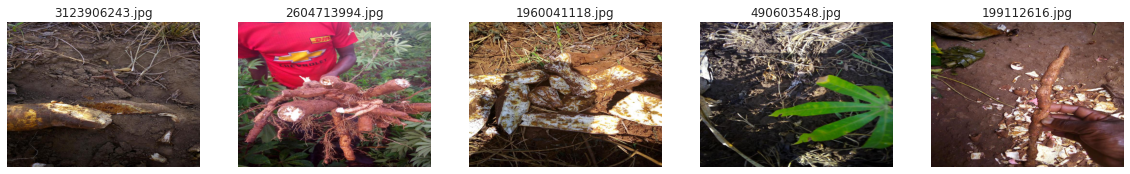

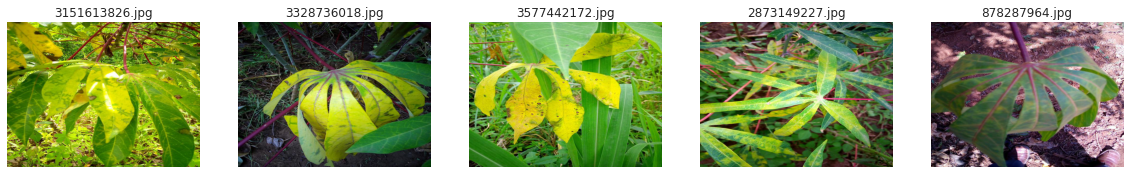

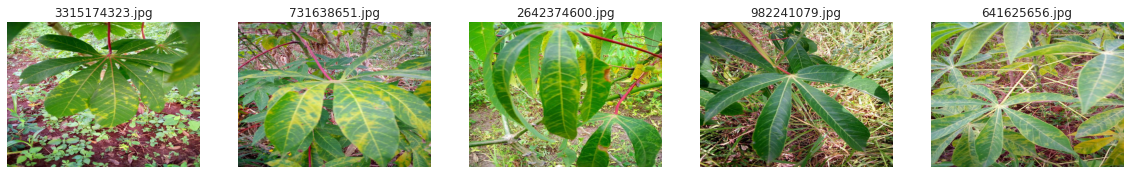

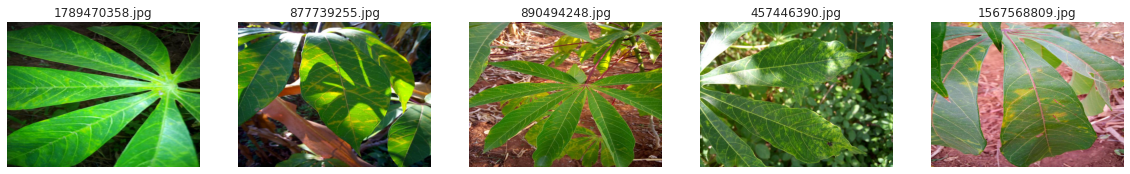

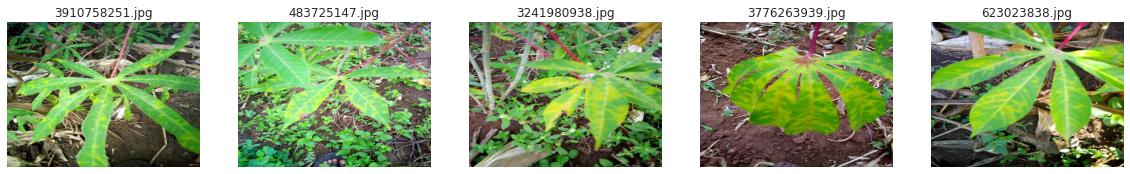

In [13]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as alb

params = {
    "lr": 0.001,
    "train_bs": 16,
    "val_bs": 16,
    "val_frac": 0.3,
    "epochs": 15,
    "pretrained":True, #SHOULDN'T BE CHANGED
    "freeze":False #SHOULDN'T BE CHANGED
}

train_df, val_df = train_test_split(training_df, test_size=params["val_frac"], stratify=training_df["label"], random_state=SEED)
groups = extract_and_cluster(train_df, label="1")
idxs = train_df[train_df["image_id"].isin(groups[0])].index
train_df.drop(idxs, axis=0, inplace=True)
data_dict = {"train":train_df, "val":val_df}

train_aug = alb.Compose([ #CHANGE AUGMENTS
    alb.ShiftScaleRotate(p=0.5),
    alb.CoarseDropout(p=0.5),
    alb.HorizontalFlip(p=0.5),
    alb.VerticalFlip(p=0.5),
    alb.RandomCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, p=0.5),
#     alb.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0)
])
val_aug = alb.Compose([ #SHOULDN'T BE CHANGED
    alb.CenterCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0)
])
augments = {"train":train_aug, "val":val_aug}


model_name = "EfficientNetB0" #CHOOSE BASE MODEL
if model_name.startswith("EfficientNet"):
    preprocess_func = tf.keras.applications.efficientnet.preprocess_input
elif model_name == "Xception":
    preprocess_func = tf.keras.applications.xception.preprocess_input
elif model_name == "InceptionV3":
    preprocess_func = tf.keras.applications.inception_v3.preprocess_input
else: #ADD ANY NECESSARY elif
    raise ValueError("Make sure desired model is imported!")
train_flow, val_flow = build_flows(data_dict, preprocess_func, augments, params) #REPLACE 'preprocess_func' WITH THE RIGHT FUNCTION

In [14]:
freqs = 1 - np.unique(train_df["label"], return_counts=True)[1]/train_df.shape[0]
loss_weights = {i:10*freqs[i] for i in range(5)} #Weights for loss function
loss = CategoricalCrossentropy(label_smoothing=0.2, from_logits=False)
# loss = SparseCategoricalCrossentropy(from_logits=False)
optimizer = Adam(learning_rate=params["lr"])

clear_session()
model = build_model(model_name, pretrained=params["pretrained"], freeze=params["freeze"])
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)
model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 16, 16, 1280)      4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


In [15]:
# model = vit.vit_l32(
#     image_size=IMAGE_SIZE,
#     activation='softmax',
#     pretrained=True,
#     include_top=True,
#     pretrained_top=False,
#     classes=5
# )

# # base_model = vit.vit_l32(
# #     image_size=IMAGE_SIZE,
# #     activation='softmax',
# #     pretrained=True,
# #     include_top=True,
# #     pretrained_top=False,
# #     classes=5
# # )

# # y = Dense(5, activation="softmax")(base_model.layers[-2].output)
# # model = Model(inputs=base_model.input, outputs=y)


# model.compile(
#      optimizer=optimizer,
#      loss=loss,
#      metrics=["accuracy"]
# )
# model.summary()

In [16]:
history = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=params["epochs"],
    class_weight=loss_weights,
    callbacks=[
#         CosineAnnealingScheduler(T_max=5, eta_min=5e-4, eta_max=1e-3, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.3, min_delta=0.001),
#         lr_scheduler,
        EarlyStopping(monitor='val_loss', patience=4, verbose=1, min_delta=0.001, restore_best_weights=True),
        ModelCheckpoint(filepath=Path(OUTPUT_DIR, model_name+"_512.h5"), monitor='val_loss', save_best_only=True)
    ]
)
# model.save(OUTPUT_DIR)

Epoch 1/15
839/839 [==============================] - 584s 696ms/step - loss: 6.4761 - accuracy: 0.7781 - val_loss: 0.9483 - val_accuracy: 0.8361
Epoch 2/15
839/839 [==============================] - 553s 659ms/step - loss: 5.9277 - accuracy: 0.8296 - val_loss: 0.9753 - val_accuracy: 0.8174
Epoch 3/15
839/839 [==============================] - 552s 658ms/step - loss: 5.7759 - accuracy: 0.8413 - val_loss: 0.9172 - val_accuracy: 0.8550
Epoch 4/15
839/839 [==============================] - 555s 661ms/step - loss: 5.6573 - accuracy: 0.8485 - val_loss: 0.9473 - val_accuracy: 0.8435
Epoch 5/15
839/839 [==============================] - 557s 664ms/step - loss: 5.6373 - accuracy: 0.8513 - val_loss: 0.8814 - val_accuracy: 0.8671
Epoch 6/15
839/839 [==============================] - 556s 663ms/step - loss: 5.5497 - accuracy: 0.8597 - val_loss: 0.8943 - val_accuracy: 0.8667
Epoch 7/15
839/839 [==============================] - 557s 663ms/step - loss: 5.5103 - accuracy: 0.8655 - val_loss: 0.8789 -

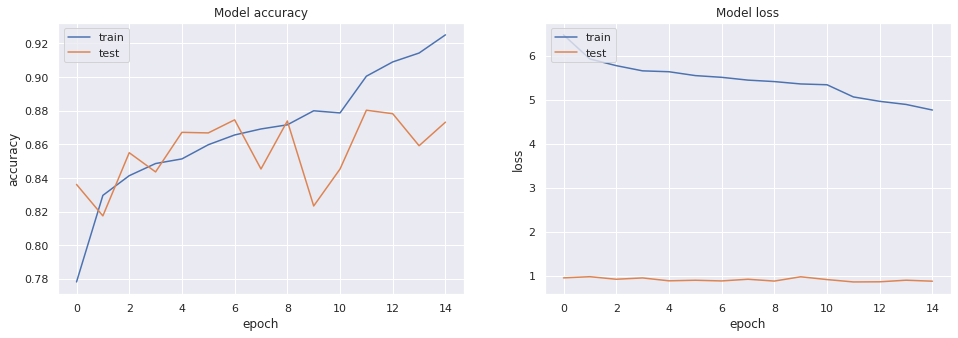

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set(xlabel="epoch", ylabel="accuracy", title="Model accuracy")
ax[0].legend(['train', 'test'])

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set(xlabel="epoch", ylabel="loss", title="Model loss")
ax[1].legend(['train', 'test'], loc='upper left')

## =======================================================

### K-folds: train K distinct models using K-fold cross-validation technique

**HOW TO USE:**
- uncomment following cells (until separator) if needed
- change "model_name" value (!!! make sure the model is imported from keras.models !!!)
- set "preprocess_func" as the corresponding preprocessing function (also make sure it is imported)
- run all

In [18]:
# from sklearn.model_selection import StratifiedKFold

# def kfold_training(model_name, preprocess_func, df, augments, params, K=3):
#     i = 1
#     kf = StratifiedKFold(n_splits=K)
#     for train_index, val_index in kf.split(df["image_id"], df["label"]):
#         print("FOLD #", i)
#         savepath = Path(OUTPUT_DIR, "{0:s}_512_fold{1:d}.h5".format(model_name, i))
        
#         train_df, val_df = df.iloc[train_index], df.iloc[val_index]
#         data_dict = {"train":train_df, "val":val_df}
#         train_flow, val_flow = build_flows(data_dict, preprocess_func, augments, params)
        
#         model = build_model(
#             model_name=model_name,
#             num_classes=5, 
#             pretrained=params["pretrained"], 
#             freeze=params["freeze"]
#         )
        
#         freqs = 1 - np.unique(train_df["label"], return_counts=True)[1]/train_df.shape[0]
#         loss_weights = {i:10*freqs[i] for i in range(5)} #Weights for loss function
#         loss = CategoricalCrossentropy(label_smoothing=0.2)
#         optimizer = Adam(learning_rate=params["lr"])
#         model.compile(
#             optimizer=optimizer,
#             loss=loss,
#             metrics=["accuracy"]
#         )
        
#         history = model.fit(
#             train_flow,
#             validation_data=val_flow,
#             class_weight=loss_weights,
#             epochs=params["epochs"],
#             callbacks=[
#                 ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.3, min_delta=0.001),
#                 EarlyStopping(monitor='val_loss', patience=4, verbose=1, min_delta=0.001, restore_best_weights=True),
#                 ModelCheckpoint(filepath=savepath, monitor='val_loss', save_best_only=True)
#             ]
#         )
        
#         i += 1
        
#     return model

In [19]:
# from sklearn.model_selection import train_test_split
# from ImageDataAugmentor.image_data_augmentor import *
# import albumentations as alb

# params = {
#     "lr": 0.001,
#     "train_bs": 32,
#     "val_bs": 16,
#     "val_frac": 0.3,
#     "epochs": 10,
#     "pretrained":True, #SHOULDN'T BE CHANGED
#     "freeze":False #SHOULDN'T BE CHANGED
# }


# K = 3 #NUMBER OF FOLDS TO CHOOSE

# train_aug = alb.Compose([ #CHANGE AUGMENTS
#     alb.ShiftScaleRotate(p=0.5),
#     alb.CoarseDropout(p=0.5),
#     alb.HorizontalFlip(p=0.5),
#     alb.VerticalFlip(p=0.5),
#     alb.RandomCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0)
# ])
# val_aug = alb.Compose([ #SHOULDN'T BE CHANGED
#     alb.CenterCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0)
# ])
# augments = {"train":train_aug, "val":val_aug}

In [20]:
# model_name = "EfficientNetB0"
# preprocess_func = tf.keras.applications.efficientnet.preprocess_input
# trained_model = kfold_training(model_name, preprocess_func, training_df, augments, params, K)

## =======================================================

### Models evaluation on reserved test set

In [21]:
# from keras.models import load_model

# kfold = False #WHETHER OR NOT USING K-FOLDS TRAINED MODELS
# if kfold:
#     models = [load_model(Path(MODELS_DIR, "EfficientNetB0_512_fold"+str(i+1)+".h5")) for i in range(3)]
# else:
#     model = load_model(Path(MODELS_DIR, "EfficientNetB0_512.hdf5"))

In [22]:
# test_datagen = ImageDataAugmentor(augment=augments["val"], 
#                                   preprocess_input=preprocess_func, 
#                                   seed=SEED
#                                  )
# test_flow = test_datagen.flow_from_dataframe(
#     test_df,
#     IMAGE_DIR,
#     x_col="image_id",
#     y_col="label",
#     class_mode="categorical",
#     target_size=TARGET_SIZE,
#     batch_size=params["val_bs"],
#     shuffle=False
# )

# if kfold:
#     preds = 0
#     for model in models:
#         preds += model.predict(test_flow, verbose=1)
#     preds /= 3
#     preds = np.argmax(preds, axis=1)
# else:
#     preds = np.argmax(model.predict(test_flow, verbose=1), axis=1)

# labels = test_df["label"].astype(int)

In [23]:
# from sklearn.metrics import accuracy_score

# accuracy_score(labels, preds)

In [24]:
# from toolbox import plot_confusion_matrix

# plot_confusion_matrix(preds, labels, normalize=True)

In [25]:
# idxs = np.where((preds == 4) & (labels == 0))[0]
# sample = test_df.iloc[idxs]
# sample.shape

In [26]:
# i = 0
# plt.figure(figsize=(20, 20))
# for image_id in sample["image_id"]:
#     image = load_img(Path(IMAGE_DIR, image_id), target_size=(224, 224))
#     plt.subplot(5, 5, i+1);
#     plt.imshow(image)
#     plt.title(image_id)
#     plt.axis('off')
#     i += 1

## =======================================================

## PyTorch

In [27]:
# #Check if GPU is activate (for PyTorch)
# import torch

# USE_GPU = True

# if USE_GPU and torch.cuda.is_available():
#     print('Using device: cuda')
# else:
#     print('Using device: cpu')

In [28]:
# import cv2
# import torch.nn as nn
# import torch.optim
# from torch.utils.data import Dataset, DataLoader
# import torchvision.models 
# from tqdm import tqdm


# class CassavaDataset(Dataset):
#     def __init__(self, data_df, image_dir, transform=None):
#         """
#         Args:
#             data_df: Pandas Df containing image IDs and labels
#             image_dir: relative path to directory containing images
#             transform: any (Albumentations) transformations, default None
#         """
#         super().__init__()
#         self.image_dir = image_dir
#         self.data_df = data_df
#         self.transform = transform

#     def __len__(self):
#         return self.data_df.shape[0]
    
#     def __getitem__(self, idx):
#         image_path = Path(self.image_dir, self.data_df.iloc[idx]["image_id"]) #Direct path to an image
#         image = mpimg.imread(image_path) #Read the image
# #         image = cv2.imread(str(image_path)) #Read the image
# #         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         label = self.data_df.iloc[idx]["label"] #Get the associated label
        
#         if self.transform:
#             image = self.transform(image=image)["image"] #Apply (Albumentations) transformation(s) to the image
#         dims = image.shape
#         image = torch.from_numpy(image.reshape(dims[-1], dims[0], dims[1])) #Transform to Tensor with right dimensions
        
#         return image, label

In [29]:
# def set_parameter_requires_grad(model, feature_extract):
#     if feature_extract:
#         for param in model.parameters():
#             param.requires_grad = False

# def initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True):
#     model = getattr(torchvision.models, model_name)(pretrained=use_pretrained)
#     set_parameter_requires_grad(model, feature_extract) #Set all requires_grad flag to False if features extraction
#     input_size = 0

#     if model_name in ["resnet18", "resnext50_32x4d"]:
#         input_size = 224

#     elif model_name == "inception_v3":
#         """
#         Be careful, expects (299,299) sized images and has auxiliary output.
#         """
#         input_size = 299
        
#         # Handle the auxilary net
#         num_features = model.AuxLogits.fc.in_features
#         model.AuxLogits.fc = nn.Linear(num_features, num_classes)
        
#     else:
#         raise ValueError("Unknown model name.")
    
#     num_features = model.fc.in_features
#     model.dropout = nn.Dropout(0.2, inplace=False)
#     model.fc = nn.Linear(num_features, num_classes)

#     return model, input_size

# def initialize_optimizer(optimizer_name, lr, model, feature_extract):
#     params_to_update = model.parameters()
#     if feature_extract:
#         params_to_update = []
#         for param in model.parameters():
#             if param.requires_grad == True:
#                 params_to_update.append(param)

#     optimizer = getattr(torch.optim, optimizer_name)(params_to_update, lr=lr)
    
#     return optimizer

In [30]:
# params = {
#     "model": "inception_v3",
#     "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
#     "lr": 0.001,
#     "train_bs": 32,
#     "val_bs": 16,
#     "val_frac": 0.2, 
#     "num_workers": 8,
#     "epochs": 10,
# }

# feature_extract = True #Whether to perform feature extraction (transfer learning) or not (finetuning)
# use_pretrained = True

# model, input_size = initialize_model(params["model"], 5, feature_extract, use_pretrained)
# model = model.to(params["device"])

# # freqs = np.unique(df_train["label"], return_counts=True)[1]
# # freqs = 1 - freqs/np.sum(freqs)
# # loss_weights = torch.from_numpy(freqs.reshape(-1, 1)).float()
# criterion = nn.CrossEntropyLoss(weight=None).to(params["device"])

# optimizer = initialize_optimizer("Adam", params["lr"], model, feature_extract)

In [31]:
# print(model)

In [32]:
# import albumentations as alb
# from albumentations.pytorch import ToTensorV2


# train_transforms = alb.Compose([
# #     alb.Resize(input_size, input_size),
#     alb.RandomCrop(height=input_size, width=input_size),
#     alb.HorizontalFlip(p=0.5),
#     alb.VerticalFlip(p=0.5),
#     alb.Normalize() #Change mean and std if not pretrained network?
# ])

# valid_transforms = alb.Compose([
# #     alb.Resize(500, 500),
#     alb.CenterCrop(height=input_size, width=input_size),
#     alb.Normalize()
# ])

In [33]:
# from imbalanced import ImbalancedDatasetSampler

# def callback_get_label(dataset, idx):
#     #callback function used in imbalanced dataset loader.
#     features, label = dataset[idx]
    
#     return label

In [34]:
# from sklearn.model_selection import train_test_split

# train_df, val_df = train_test_split(df_train, stratify=df_train["label"], 
#                                     test_size=params["val_frac"], random_state=SEED)
# val_df.reset_index(drop=True, inplace=True)

# train_set = CassavaDataset(
#     data_df=train_df,
#     image_dir=IMAGE_DIR,
#     transform=train_transforms
# )

# val_set = CassavaDataset(
#     data_df=val_df,
#     image_dir=IMAGE_DIR,
#     transform=valid_transforms
# )

# train_loader = DataLoader(
#     train_set,
# #     sampler=ImbalancedDatasetSampler(train_set, callback_get_label=callback_get_label),
#     batch_size=params["train_bs"], 
#     shuffle=True, 
#     num_workers=params["num_workers"],
#     pin_memory=True,
#     drop_last=True
# )

# val_loader = DataLoader(
#     val_set, 
#     batch_size=params["val_bs"], 
#     shuffle=False, 
#     num_workers=params["num_workers"],
#     pin_memory=True,
#     drop_last=True
# )

In [35]:
# class MetricMonitor:
#     def __init__(self, float_precision=3):
#         self.float_precision = float_precision
#         self.reset()

#     def reset(self):
#         self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

#     def update(self, metric_name, val):
#         metric = self.metrics[metric_name]

#         metric["val"] += val
#         metric["count"] += 1
#         metric["avg"] = metric["val"] / metric["count"]

#     def __str__(self):
#         return " | ".join(
#             [
#                 "{metric_name}: {avg:.{float_precision}f}".format(
#                     metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
#                 )
#                 for (metric_name, metric) in self.metrics.items()
#             ]
#         )

# def multi_acc(targets, preds):
#     """
#     Multi-class accuracy function.
#     """
#     preds_softmax = torch.log_softmax(preds, dim=1)
#     preds_labels = torch.argmax(preds, dim=1, keepdim=True)    
    
#     correct = (preds_labels == targets).float()
#     acc = correct.sum().item()/len(correct)
    
#     return acc


# def train(train_loader, model, criterion, optimizer, epoch, params, is_inception=False):
#     metric_monitor = MetricMonitor()
    
#     model.train()
#     stream = tqdm(train_loader)
#     for i, (images, labels) in enumerate(stream, start=1):
#         images = images.to(params["device"], non_blocking=True).float()
#         labels = labels.to(params["device"], non_blocking=True).long()
        
#         if is_inception:
#             outputs, aux_outputs = model(images)
#             loss1 = criterion(outputs, labels)
#             loss2 = criterion(aux_outputs, labels)
#             loss = loss1 + 0.4*loss2
#         else:
#             outputs = model(images)
#             loss = criterion(outputs, labels) 
#         accuracy = multi_acc(labels.view(-1, 1), outputs)
        
#         metric_monitor.update("Loss", loss.item())
#         metric_monitor.update("Accuracy", accuracy)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         stream.set_description(
#             "Epoch: {}. Train. {}".format(epoch, metric_monitor)
#         )


# def validate(val_loader, model, criterion, epoch, params):
#     metric_monitor = MetricMonitor()
    
#     model.eval()
#     stream = tqdm(val_loader)
#     with torch.no_grad():
#         for i, (images, labels) in enumerate(stream, start=1):
#             images = images.to(params["device"], non_blocking=True).float()
#             labels = labels.to(params["device"], non_blocking=True).long()
#             outputs = model(images)
            
#             loss = criterion(outputs, labels)
#             accuracy = multi_acc(labels.view(-1, 1), outputs)
            
#             metric_monitor.update("Loss", loss.item())
#             metric_monitor.update("Accuracy", accuracy)
#             stream.set_description(
#                 "Epoch: {}. Validation. {}".format(epoch, metric_monitor)
#             )

In [36]:
# import copy
# import time
# from collections import defaultdict

# is_inception = (params["model"] == "inception_v3")
# train_values, val_values = {"loss":[], "acc":[]}, {"loss":[], "acc":[]}
# best_loss = 1000 #Random very high value
# train_time = 0
# for epoch in range(1, params["epochs"]+1):
#     start = time.time()
#     train(train_loader, model, criterion, optimizer, epoch, params, is_inception)
#     end = time.time()
#     train_time += end-start
#     validate(val_loader, model, criterion, epoch, params)
    
# #     train_values["loss"].append(train_loss)
# #     train_values["acc"].append(train_acc)
# #     val_values["loss"].append(val_loss)
# #     val_values["acc"].append(val_acc)
# #     print("Train accuracy: {}, Validation accuracy: {}".format(train_acc, val_acc))
    
# #     if val_loss < best_loss:
# #         best_loss = val_loss
# #         best_model_state = copy.deepcopy(model.state_dict())
# #         torch.save(best_model_state, Path(OUTPUT_DIR, "best_state.pth"))

# print(train_time)

In [37]:
# fig, ax = plt.subplots(1, 2, figsize=(16, 5))
# ax[0].plot(train_values["loss"], label="train")
# ax[0].plot(val_values["loss"], label="val")
# ax[0].set_title("Loss values")
# ax[0].legend()

# ax[1].plot(train_values["acc"], label="train")
# ax[1].plot(val_values["acc"], label="val")
# ax[1].set_title("Accuracy values")
# ax[1].legend()

# fig.savefig(Path(OUTPUT_DIR, "results.png"))

In [38]:
# class CassavaInferenceDataset(Dataset):
#     def __init__(self, csv_file, image_dir, transform=None):
#         """ 
#         Args:
#             csv_file: relative path to csv file
#             image_dir: relative path to directory containing images
#             transform: any (Albumentations) transformations, default None
#         """
#         self.image_dir = image_dir
#         self.data_name = pd.read_csv(Path(csv_file)) #.csv file containing image IDs and labels
#         self.transform = transform

#     def __len__(self):
#         return self.data_name.shape[0]

#     def __getitem__(self, idx):
#         image_path = Path(self.image_dir, self.data_name.iloc[idx]["image_id"]) #Direct path to an image
#         image = mpimg.imread(image_path) #Read the image
        
#         if self.transform:
#             image = self.transform(image=image)["image"] #Apply (Albumentations) augmentation(s) to the image
#         dims = image.shape
#         image = torch.from_numpy(image.reshape(dims[-1], dims[0], dims[1])) #Transform to Tensor with right dimensions

#         return image